In [12]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import glob
import pandas as pd
from scipy.io import arff
import logging
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from tools.clustering.fuzzy_cmeans import FuzzyCMeansParamsGrid
from tools.clustering import PARAMS_GRID_MAP
from tools.config import DATA_DIR, CLUSTERED_DATA_DIR

plt.style.use('default')

# Set up logger
logger = logging.getLogger(__name__)

In [2]:
CLUSTERED_DATA_DIR
model_name = 'fuzzy_cmeans'
dataset_name = 'vowel'

In [3]:
SCRIPT_DIR = pathlib.Path(os.getcwd()).absolute()
DATA_DIR = os.path.join(SCRIPT_DIR.parent, "data")
PREPROCESSED_DATA_DIR = f'{DATA_DIR}/1_preprocessed/'

In [4]:
data_path = f"{DATA_DIR}/1_preprocessed/synthetic.csv"
df  = pd.read_csv(data_path)
df['class'].unique()


array([1, 2, 4, 3, 0])

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

METRICS_FILE_PATH = f"{DATA_DIR}/3_metrics.csv"
data = pd.read_csv(METRICS_FILE_PATH)

# Ensure numerical columns are properly parsed (if needed)
# data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')
# data['ari'] = pd.to_numeric(data['ari'], errors='coerce')
# data['purity'] = pd.to_numeric(data['purity'], errors='coerce')
# data['dbi'] = pd.to_numeric(data['dbi'], errors='coerce')
# data['f_measure'] = pd.to_numeric(data['f_measure'], errors='coerce')

data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]

/var/folders/0m/k4sjt9f13nq8h9cxt8052ykh0000gn/T/ipykernel_89917/1118703523.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]
/var/folders/0m/k4sjt9f13nq8h9cxt8052ykh0000gn/T/ipykernel_89917/1118703523.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]


,dataset,model,runtime,dbi,chi,ari,f_measure,n_clusters,fuzzyness,max_iterations,...,max_depth,metric,algorithm,min_samples,xi,min_cluster_size,n_neighbors,affinity,eigen_solver,assign_labels
961,mushroom,fuzzy_cmeans,0.132461,2.808719,984.595671,0.600548,0.887184,2.0,1.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
962,mushroom,fuzzy_cmeans,0.199084,2.810931,984.293029,0.605136,0.888682,2.0,2.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963,mushroom,fuzzy_cmeans,0.119384,3.478447,666.685647,0.013959,0.559084,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
964,mushroom,fuzzy_cmeans,0.149267,1.854090,1295.423663,0.212442,0.702997,2.0,3.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
965,mushroom,fuzzy_cmeans,0.098206,1.854090,1295.423663,0.212442,0.702997,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
966,mushroom,fuzzy_cmeans,0.196777,2.683925,1072.226462,0.748343,0.931844,2.0,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
967,mushroom,fuzzy_cmeans,0.171795,1.857471,1294.417394,0.213353,0.703638,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
968,mushroom,fuzzy_cmeans,0.135145,1.862484,1292.859287,0.214724,0.704599,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
model_name = 'fuzzy_cmeans'

In [7]:
models = data['model'].unique()
datasets = data['dataset'].unique()

In [8]:
# data_for_method = data[data['model'] == model_name] 
params_for_method = list(PARAMS_GRID_MAP[model_name].keys())
datasets, params_for_method

(array(['hepatitis', 'mushroom', 'vowel'], dtype=object),
 ['n_clusters', 'fuzzyness'])

In [9]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def custom_boxplot(ax, data):
    print('boxplot data', data[0])
    ax.boxplot(
        data,
        patch_artist=True,  # Fill boxes with color
        medianprops={"color": "blue", "linewidth": 2},  # Style median lines
        flierprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgewidth": 1,
            "markersize": 4,
        },  # Style outlier points
        boxprops={"facecolor": "lightblue", "alpha": 0.7},  # Style boxes
        whiskerprops={"linestyle": "--"},  # Style whiskers
        capprops={"linewidth": 2},  # Style caps
    )
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    ax.set_axisbelow(True)  # Put grid behind plot elements
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

In [10]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def plot_interactions_with_gridspec(df, col_names, datasets, model_name):
    num_cols = len(col_names)
    total_datasets = len(datasets)

    # Create the main figure and grid for datasets
    fig = plt.figure(figsize=(15 * total_datasets, 6 * num_cols))
    outer_grid = GridSpec(1, total_datasets, figure=fig, wspace=0.1)

    # Prepare a placeholder for the colorbar data
    heatmap_min, heatmap_max = np.inf, -np.inf

    for dataset_idx, dataset_name in enumerate(datasets):
        # Create a sub-grid for each dataset within the main grid
        inner_grid = GridSpecFromSubplotSpec(
            num_cols, num_cols, subplot_spec=outer_grid[dataset_idx],
        )

        filtered_df = df[(df['dataset'] == dataset_name) & (df['model'] == model_name)]
        axes = []

        for i, ((col_name1, col_name2), inner_idx) in enumerate(
            zip(itertools.product(col_names, repeat=2), range(num_cols * num_cols))
        ):
            row = inner_idx // num_cols
            col = inner_idx % num_cols

            ax = fig.add_subplot(inner_grid[row, col])
            axes.append(ax)


            # Skip plots above the diagonal
            if col > row:
                ax.axis("off")
                continue

            

            if col_name1 == col_name2:
                # Diagonal-like plots: Single-variable distribution (boxplot)
                unique_vals = filtered_df[col_name1].unique()
            
                if np.issubdtype(unique_vals.dtype, np.number):
                    unique_vals.sort()
                    
                sorted_data = [
                    filtered_df[filtered_df[col_name1] == val]["f_measure"].tolist()
                    for val in unique_vals
                ]
                
                custom_boxplot(ax, sorted_data)
                
                ax.set_xticklabels(unique_vals)
                ax.set_xlabel(f"{col_name1}", fontsize=10)
                ax.set_ylabel("F1 measure", fontsize=10)
                # ax.set_title(f"{col_name1}", fontsize=10)
            else:
                # Off-diagonal: Interaction heatmap
                pivot_table = filtered_df.pivot_table(
                    values="f_measure", index=col_name1, columns=col_name2, aggfunc="mean"
                )
                sns.heatmap(
                    pivot_table,
                    ax=ax,
                    cmap="viridis",
                    annot=False,
                    # fmt=".2f",
                    cbar=False,
                )
                # ax.set_title(f"{col_name1} vs {col_name2}", fontsize=8)

                # Update the global min and max for the colorbar
                if pivot_table.values.size > 0:  # Check if pivot_table is not empty
                    heatmap_min = min(heatmap_min, np.nanmin(pivot_table.values))
                    heatmap_max = max(heatmap_max, np.nanmax(pivot_table.values))

            # Style: Remove ticks for clarity
            # ax.set_xticks([])
            # ax.set_yticks([])

        # Add a title for the entire dataset grid
        inner_title = fig.add_subplot(outer_grid[dataset_idx])
        inner_title.axis("off")
        inner_title.set_title(dataset_name, fontsize=14, fontweight="bold")

    
    # # Add row labels and y-ticks only on the leftmost plots
    # for i in range(num_cols):
    #     if i < len(axes) and axes[i * num_cols]:  # Check if the subplot exists
    #         axes[i * num_cols].set_ylabel(col_names[i], fontsize=12, rotation=90)
    #         unique_vals = (
    #             sorted(filtered_df[col_names[i]].unique())
    #             if pd.api.types.is_numeric_dtype(filtered_df[col_names[i]])
    #             else filtered_df[col_names[i]].unique()
    #         )
    #         axes[i * num_cols].set_yticks(np.arange(len(unique_vals)) + 0.5)
    #         axes[i * num_cols].set_yticklabels(unique_vals, rotation=15)

    # # Add column labels and x-ticks only on the bottom plots
    # for j in range(num_cols):
    #     if (num_cols - 1) * num_cols + j < len(axes):  # Check if the subplot exists
    #         unique_vals = (
    #             sorted(filtered_df[col_names[j]].unique())
    #             if pd.api.types.is_numeric_dtype(filtered_df[col_names[j]])
    #             else filtered_df[col_names[j]].unique()
    #         )
    #         axes[(num_cols - 1) * num_cols + j].set_xticks(np.arange(len(unique_vals)) + 0.5)
    #         axes[(num_cols - 1) * num_cols + j].set_xticklabels(unique_vals, rotation=15)
    #         axes[(num_cols - 1) * num_cols + j].set_xlabel(col_names[j], fontsize=12)



    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.75])  # [left, bottom, width, height]
    norm = plt.Normalize(heatmap_min, heatmap_max)
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label="F1 Score", orientation="vertical")

    
    # Add a global title for the entire plot
    fig.suptitle(f'Interaction Effects of {model_name} Parameters Across Datasets', fontsize=18, fontweight="bold")
    # fig.tight_layout()
    return fig


boxplot data [0.6728577458843394, 0.655937846836848, 0.6671956684092606, 0.655937846836848, 0.6695722203799328, 0.6503383822107638, 0.6695722203799328, 0.6503383822107638]
boxplot data [0.0839246119733924, 0.0714285714285714, 0.0723226049313005, 0.6728577458843394, 0.3896103896103896, 0.2723316536875859, 0.2136517328825021, 0.1392107784061061, 0.1227166276346604, 0.1019463087248322, 0.1129343629343629]
boxplot data [0.8871836384934797, 0.8886818644594594, 0.559084105226314, 0.7029972242131595, 0.7029972242131595, 0.9318443855212154, 0.7036383558715057, 0.7045989617498782]
boxplot data [0.0970389932087, 0.0847861692438502, 0.0815115316415268, 0.8871836384934797, 0.5069315155573019, 0.3055760033841342, 0.2048843199185356, 0.1980715989014319, 0.1635745830671639, 0.1090756884824986, 0.1029855969386836]
boxplot data [0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291, 0.0279557926244291]
boxplot data [0.

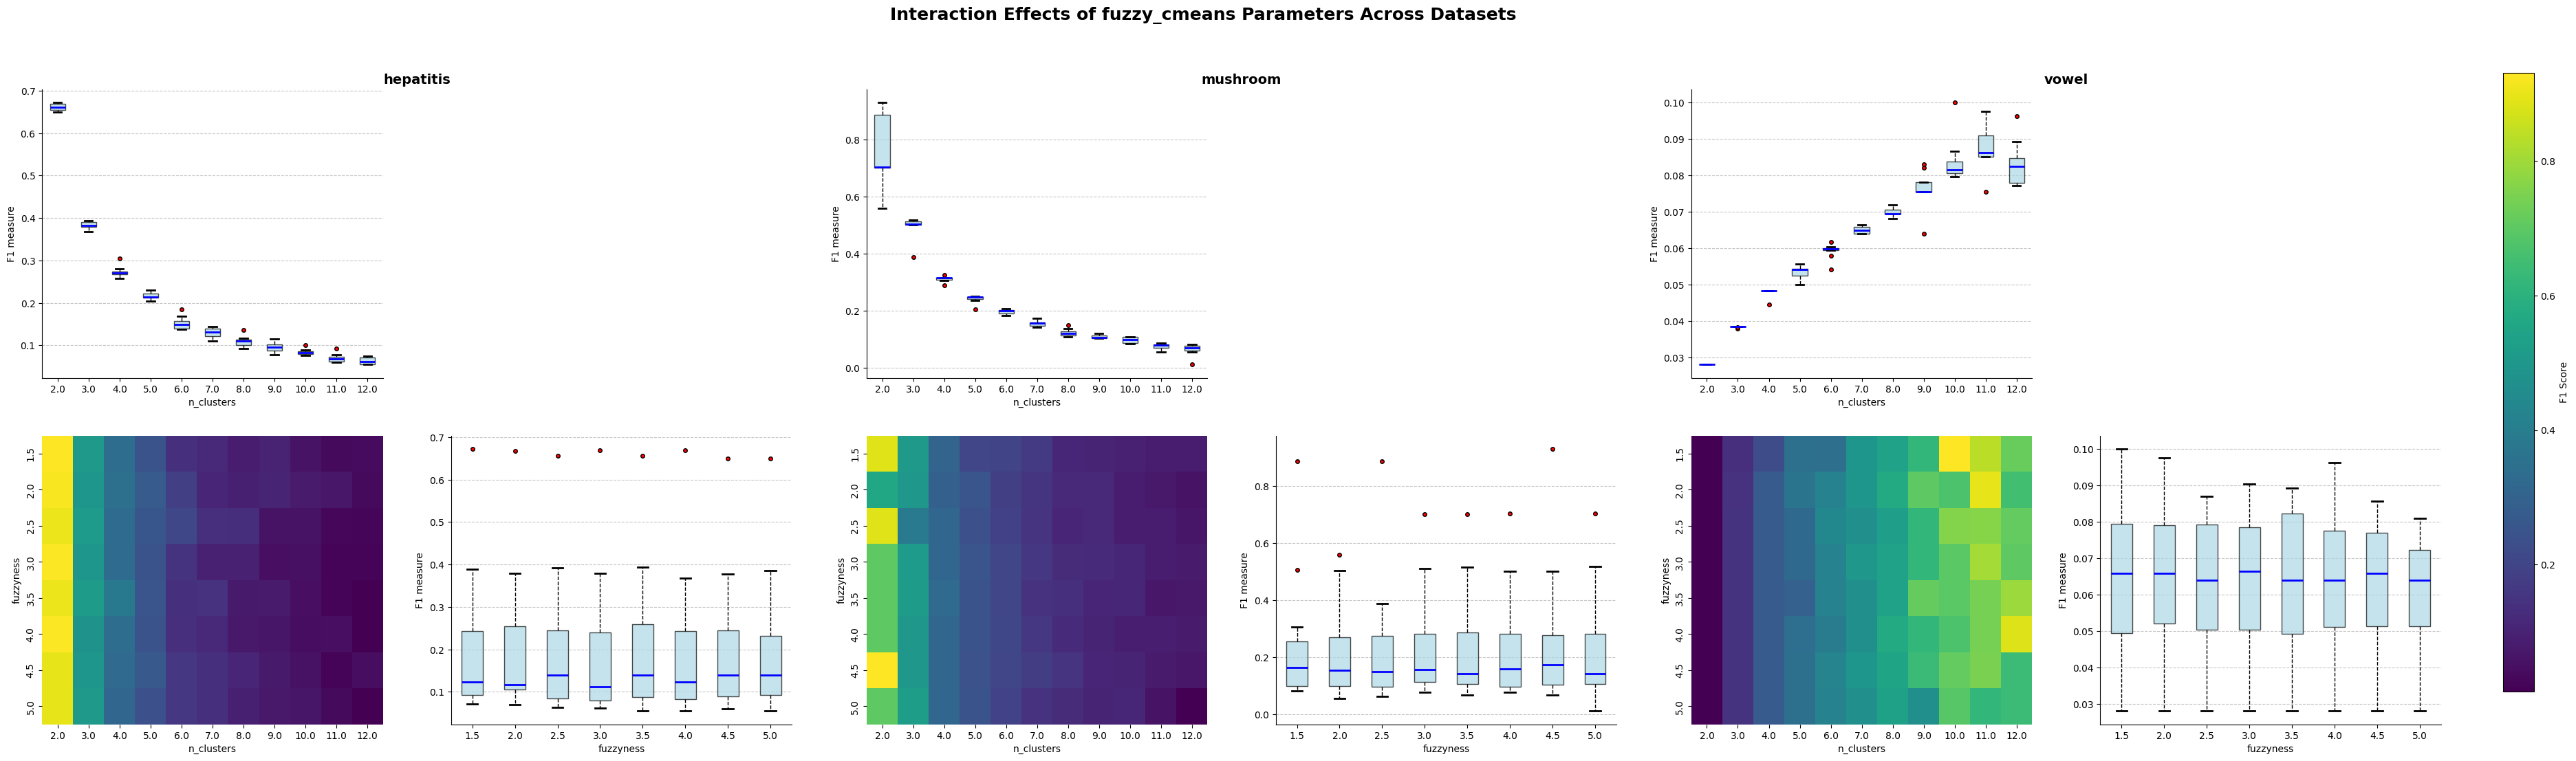

In [13]:
fig = plot_interactions_with_gridspec(
    data,
    params_for_method,
    datasets,
    model_name
)
# fig.suptitle('Interaction Effects of Fu Model Parameters on F1 Score', fontsize=20, fontweight='bold')
# fig.subplots_adjust(top=0.95)
# fig.savefig('../reports/figures/interaction_effects_KNN.png', dpi=300)
plt.show()